**Air Pollution Forecasting Using RNN-LSTM**

Project By: Vivin T 

In [ ]:
#Import the necesarry libraries
from pandas import read_csv
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from math import sqrt
from numpy import concatenate

In [ ]:
# load and process data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('/content/data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
print("||"*40)
print("** DATA PROCESSING COMPLETED **")
print(dataset.head(5))
print("||"*40)
dataset.to_csv('/content/pollution.csv')

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
** DATA PROCESSING COMPLETED **
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


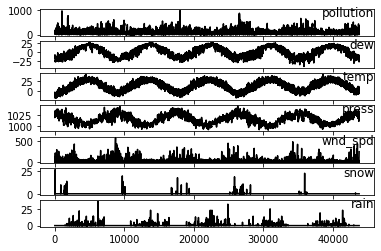

In [ ]:
# generating dataset plot
dataset = read_csv('/content/pollution.csv', header=0, index_col=0)
values = dataset.values
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group],'k')
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [ ]:
# Lets normalize all features, and remove the weather variables for the hour to be predicted.


def s_to_super(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
# load dataset
dataset = read_csv('/content/pollution.csv', header=0, index_col=0)
values = dataset.values
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = s_to_super(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("** NOT REQUIRED DATA COLUMNS DROPPED **")
print("||"*40)

** NOT REQUIRED DATA COLUMNS DROPPED **
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# split data into training and testing, futher splitting the train and test sets into i/p and o/p variables
# reshaped data further into 3D formate expected by LSTMs
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("** DATA SPLITTING COMPLETED **")
print(" Training data shape X, y => ",train_X.shape, train_y.shape," Testing data shape X, y => ", test_X.shape, test_y.shape)
print("||"*40)

** DATA SPLITTING COMPLETED **
 Training data shape X, y =>  (8760, 1, 8) (8760,)  Testing data shape X, y =>  (35039, 1, 8) (35039,)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# defining LSTM with 50 neurons in first hidden layer and 1 neuron in the o/p layer
# using the MAE loss function and Adma version of stochastic gradient descent
model = Sequential()
# 50 neurons in first hidden layer
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - loss: 0.2913 - val_loss: 0.1220
Epoch 2/50
122/122 - 1s - loss: 0.0893 - val_loss: 0.0746
Epoch 3/50
122/122 - 1s - loss: 0.0754 - val_loss: 0.0711
Epoch 4/50
122/122 - 1s - loss: 0.0723 - val_loss: 0.0684
Epoch 5/50
122/122 - 1s - loss: 0.0687 - val_loss: 0.0656
Epoch 6/50
122/122 - 1s - loss: 0.0651 - val_loss: 0.0627
Epoch 7/50
122/122 - 1s - loss: 0.0610 - val_loss: 0.0595
Epoch 8/50
122/122 - 1s - loss: 0.0565 - val_loss: 0.0561
Epoch 9/50
122/122 - 1s - loss: 0.0514 - val_loss: 0.0532
Epoch 10/50
122/122 - 1s - loss: 0.0457 - val_loss: 0.0507
Epoch 11/50
122/122 - 1s - loss: 0.0409 - val_loss: 0.0475
Epoch 12/50
122/122 - 1s - loss: 0.0372 - val_loss: 0.0451
Epoch 13/50
122/122 - 1s - loss: 0.0354 - val_loss: 0.0415
Epoch 14/50
122/122 - 1s - loss: 0.0342 - val_loss: 0.0385
Epoch 15/50
122/122 - 1s - loss: 0.0330 - val_loss: 0.0360
Epoch 16/50
122/122 - 1s - loss: 0.0321 - val_loss: 0.0340
Epoch 17/50
122/122 - 1s - loss: 0.0316 - val_loss: 0.0327
Epoch 

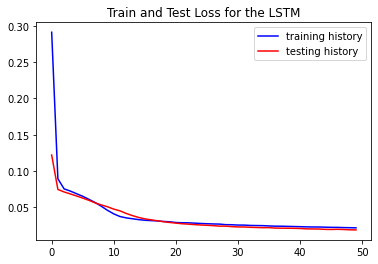

In [ ]:
# tracking history for plots
pyplot.plot(history.history['loss'], 'b', label='training history')
pyplot.plot(history.history['val_loss'],  'r',label='testing history')
pyplot.title("Train and Test Loss for the LSTM")
pyplot.legend()
pyplot.show()

In [ ]:
# evaluating model
# make a prediction

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 17.524
